In [3]:
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as rt
import onnx
import pandas as pd

from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing
from constants import protected_attributes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
import aif360.sklearn.metrics as skm

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, \
                              false_positive_rate, \
                              selection_rate, equalized_odds_ratio, false_negative_rate

d:\tudelft\test-val-for-ai-project\.env\Lib\site-packages\torch\_functorch\deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


## Metamorphic testing class (works with pre-trained onnx models)

Helper Functions for metapmorphic testing

In [4]:
from onnxruntime.capi.onnxruntime_pybind11_state import InvalidArgument

def test_metamorphic(data, feature_name : str, is_Fraud: bool ,value_from : int, value_to: int, model_path : str):
    data_modified = data.copy() 
    is_checked = 1 if is_Fraud else 0
    test_data= data_modified.loc[data_modified['checked'] == is_checked]
    test_data = test_data.loc[test_data[feature_name] == value_from]
    data_wout = test_data.copy()
    y_wout = data_wout['checked']
    X_wout= data_wout.drop(['checked'], axis=1)
    X_wout = X_wout.astype(np.float32)
    test_data[feature_name] = value_to
    y_test = test_data['checked']
    X_test= test_data.drop(['checked'], axis=1)
    X_test = X_test.astype(np.float32)
    session = rt.InferenceSession(model_path)
        
    try:
        y_pred_onnx1 =  session.run(None, {'X': X_wout.values.astype(np.float32)})
        y_pred_onnx2 =  session.run(None, {'X': X_test.values.astype(np.float32)})
        y_pred_onnx1_np = np.array(y_pred_onnx1[0])
        y_pred_onnx2_np = np.array(y_pred_onnx2[0])
        diff_count = np.sum(y_pred_onnx1_np != y_pred_onnx2_np)
        return diff_count, len(y_pred_onnx1_np)
    except InvalidArgument:
        #print("Got error: empty test dataframe. " "Column is: ", feature_name, " combo is:", is_Fraud, value_from, value_to)
        return 0, 0
    # assert y_pred_onnx1[0].all() == y_pred_onnx2[0].all(), f'Model predictions are different. The model has bias towards {feature_name} with value {value_from} '
    # return True

def plot_metamorphic_results(pre_trained_models):
    data = []
    for model in pre_trained_models:
        # Extract the percentage (it's the 2nd tuple value) and multiply it with 100
        data.append([tup[1]*100 for tup in model.column_avg])
    
    plt.boxplot(data)
    # Add title and labels
    plt.title('Box Plot of Arrays')
    plt.xlabel('Arrays')
    plt.ylabel('Values')

    # Show the plot
    plt.show()

Making a class that tests all combinations of feature values in metamorphic testing

In [5]:
class MetamorphicTester:
    def __init__(self, data_path, model_path):
        self.model = model_path
        self.df = pd.read_csv(data_path)
        self.mutation_test_results = {}
        self.column_avg = None
        self.global_average = None
        
    def test(self):
        # Iterate over each column in the DataFrame and generate the mutation test combinations
        for column in self.df.columns:
            # Get unique values for the current column
            unique_values = self.df[column].unique()
            if len(unique_values) > 1:
                # We sample two random values from the unique options, and store this in the dictionary
                rand_values = np.random.choice(unique_values, size=2, replace=False)
                combos = []
                for bool in [True, False]:
                    for a in rand_values:
                        for b in rand_values:
                            combos.append([bool, a, b])
                
                self.mutation_test_results[column] = combos
        
        # Go over each combination and get how many tests failed to kill the mutation
        for column, values in self.mutation_test_results.items():
            for combo in values:
                num_differ, length = test_metamorphic(self.df, column, combo[0], combo[1], combo[2], self.model)
                combo.append(num_differ)
                combo.append(length)
    
    def analyse_test(self):
        # We can now do some basic data analysis.
        # We can compute a score on a per-column basis, getting an average across 8 tests of what percentage of mutants were failed to kill
        # We can also compute a sort of global metric. Just an average across all mutations
        column_avg = []
        all_percentages = []
        
        for column, values in self.mutation_test_results.items():
            percentages = []
            for combo in values:
                # compute percentage, and add it to a temp array to compute the average value
                if combo[4] != 0:
                    res = combo[3]/combo[4]
                    percentages.append(res)
                    all_percentages.append(res)
            column_avg.append((column, np.mean(np.array(percentages))))
        
        column_avg = sorted(column_avg, key=lambda x: x[1], reverse=True)
        
        # Save the results
        self.column_avg = column_avg
        self.global_average = np.mean(np.array(all_percentages)) * 100

# features_to_ignore = ["adres_dagen_op_adres", "afspraak_aantal_woorden", "afspraak_laatstejaar_aantal_woorden", "belemmering_dagen_financiele_problemen", 
#                       "belemmering_dagen_lichamelijke_problematiek", "belemmering_dagen_psychische_problemen", "contacten_onderwerp_overige", "contacten_onderwerp_terugbelverzoek", "contacten_onderwerp_traject", "contacten_soort_afgelopenjaar_document__uitgaand_", 
#                       "contacten_soort_document__inkomend_", "contacten_soort_document__uitgaand_", "contacten_soort_e_mail__inkomend_", "contacten_soort_e_mail__uitgaand_", "contacten_soort_telefoontje__inkomend_", "contacten_soort_telefoontje__uitgaand_", 
#                       "deelname_act_reintegratieladder_werk_re_integratie", "ontheffing_dagen_hist_mean", "ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden", "persoon_leeftijd_bij_onderzoek", "persoonlijke_eigenschappen_dagen_sinds_opvoer", "persoonlijke_eigenschappen_dagen_sinds_taaleis", "persoonlijke_eigenschappen_spreektaal", "relatie_kind_leeftijd_verschil_ouder_eerste_kind", "typering_dagen_som"]



## Setting up a class to do mutation testing (requires training)

In [6]:
def mutation(key):
  def do_assignment(to_func):
    to_func.key = key
    return to_func
  return do_assignment


class MutationTester:
    def __init__(self, y_pred_baseline, df_train, df_test):
        self.y_pred_baseline = y_pred_baseline
        self.df_train = df_train
        self.df_test = df_test
    
    
    def test_mutants(self, params, n_mutants=5):
        
        mutants = [getattr(self, field) for field in dir(self) if hasattr(getattr(self, field), "key")]
        
        mutation_scores = {}
        
        for mutant in mutants:
            
                n_mutations_killed = 0

                for _ in range(n_mutants):
                    data = mutant(params[mutant.key])
                    X_train_mutant = data.iloc[:, :-1]
                    y_train_mutant = data.iloc[:, -1]
                    
                    mutant_model = GradientBoostingClassifier()
                    mutant_model.fit(X_train_mutant, y_train_mutant)
                    
                    X_test = self.df_test.iloc[:, :-1]
                    y_test = self.df_test.iloc[:, -1]
                    y_pred_mutant = mutant_model.predict(X_test)

                    """
                        REFERENCE: https://sci-hub.se/10.1109/icst46399.2020.00018
                        The mutation score metric in DeepMutation is defined only for classification systems. 
                        More specifically, in case of a kclassification problem with a set of classes C = {c1, ..., ck}, 
                        a test input t ∈ T kills the pair c, m, with class c ∈ C and mutant m ∈ M, 
                        if t is correctly classified as c by the original model and if t is misclassified by the mutant model m. 
                        Based on this, the mutation score is calculated as the ratio of killed classes per mutant m over the product of the sizes of M and C
                    """
                    killed = (y_pred_mutant == y_test) & (self.y_pred_baseline != y_test)
                    
                    n_mutations_killed += sum(killed)
                mutation_scores[mutant.key] = n_mutations_killed / (n_mutants * 2)
        
        return mutation_scores
                
    """
    The given training data is shuffled in a random order. Specifically, a random data point is swapped with another, 
    this is done equal to the iterations parameter number of times 
    """
    @mutation('data_shuffler')
    def data_shuffler(self, iterations=1000):
        shuffled_data = self.df_train.copy()
        num_rows = len(self.df_train)
        
        for i in range(iterations):
            # Choose two random indices for swapping
            idx1, idx2 = np.random.randint(0, num_rows, 2)
    
            # Swap rows at random two indices
            shuffled_data.iloc[idx1], shuffled_data.iloc[idx2] = (
                shuffled_data.iloc[idx2].copy(),
                shuffled_data.iloc[idx1].copy(),
            )
        return shuffled_data

    """
    A fixed percentage of the training data is removed (at random)
    """
    @mutation('data_remover')
    def data_remover(self, percent=0.1):
        # Calculate the number of rows to remove based on the percentage
        num_rows_to_remove = int(len(self.df_train) * percent)
        smaller_df = self.df_train.copy()
        return smaller_df.drop(smaller_df.sample(n=num_rows_to_remove).index)
    
    """
    Chosen randomly, the values of a row of the training data is replicated into another row. This is done
    iterations number of times
    """
    @mutation('data_repetition')
    def data_repetition(self, iterations=1000):
        repeated_data = self.df_train.copy()
        num_rows = len(self.df_train)
        
        for i in range(iterations):
            # Choose two random indices. The value of the first will be duplicated onto the 2nd
            idx1, idx2 = np.random.randint(0, num_rows, 2)
            repeated_data.iloc[idx2] = repeated_data.iloc[idx1].values
        return repeated_data
    
    @mutation('label_error')
    def label_error(self, num_rows=1000):
        assert num_rows < len(self.df_train), "Please chose to alter the labels of less training data"
        changed_data = self.df_train.copy()
        # Get the indices of rows that will have their labels changed
        rows_to_change = np.random.choice(self.df_train.index, num_rows, replace=False)
        
        # Change the values of the last column ("checked") for the randomly selected rows (0 becomes 1 and vice versa)
        changed_data.loc[rows_to_change, self.df_train.columns[-1]] = 1 - changed_data.loc[rows_to_change, self.df_train.columns[-1]]
        
        return changed_data
    
    @mutation('feature_remover')
    def feature_remover(self, n_features=31):
        removed_feature_data = self.df_train.copy()
        drop_features = np.random.choice(self.df_train.columns, n_features)
        # We set all values to zero as a proxy for dropping the features. This allows for easier comparison.
        for col in drop_features: 
            removed_feature_data[col].values[:] = 0
        return removed_feature_data

## Functional test class (can work with training or without)


In [7]:
class FunctionalTester:
    def __init__(self, model_path):
        self.model = model_path
    
    """
    Evaluates the model and returns performance metrics
    """
    def evaluate_model(self, X_test, y_test):
        session = rt.InferenceSession(self.model)
        y_pred = session.run(None, {'X': X_test.values.astype(np.float32)})[0]
        print(y_pred)
        TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

        # Overall accuracy
        ACC = (TP + TN) / (TP + TN + FP + FN)
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        f1 = f1_score(y_test, y_pred)

        return {
            "TN": TN,
            "FP": FP,
            "FN": FN,
            "TP": TP,
            "fpr": FPR,
            "tnr": TNR,
            "tpr": TPR,
            "fnr": FNR,
            "acc": ACC,
            "precision": PPV,
            "f1": f1,
            "PPV": PPV,
            "NPV": NPV,
            "FDR": FDR
    }

## Test Cases

Doing some metamorphic testing

In [17]:
data = pd.read_csv("./../data/synth_data_for_training.csv")
model_path = "./../model/good_model.onnx"

In [8]:
t1 = test_metamorphic(data, "adres_aantal_brp_adres", True, 11, 11, model_path)
t2 = test_metamorphic(data, 'persoon_geslacht_vrouw', True, 0, 1, model_path) #test if changing gender of women who are frauds to men to see if predictions change to not fraud
t3 = test_metamorphic(data, 'persoon_geslacht_vrouw', False, 0, 1, model_path) #test if changing gender of men who are not frauds to women to see if predictions change to not fraud
t4 = test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', True, 0, 1, model_path) #test if changing non dutch speaker people who are frauds to dutch speaking to see if predictions change to not fraud
t5 = test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', False, 1, 0, model_path) #test if changing dutch speaker people who are not frauds to non-dutch speaking to see if predictions change to fraud
t6 = test_metamorphic(data, 'persoonlijke_eigenschappen_taaleis_voldaan', True, 2, 1, model_path) #test if changing people who are frauds and did no take the dutch exam to dutch speaking to see if predictions change to not fraud
print(t1, t2, t3, t4, t5, t6)

(0, 0) (9, 663) (4, 5879) (14, 708) (3, 6558) (0, 104)


In [45]:
baseline = MetamorphicTester('./../data/train.csv', './../model/baseline_model.onnx')
baseline.test()
baseline.analyse_test()

good_model = MetamorphicTester('./../data/synth_data_for_training.csv', './../model/good_model.onnx')
good_model.test()
good_model.analyse_test()

In [9]:
models = [baseline, good_model]
plot_metamorphic_results(models)

NameError: name 'baseline' is not defined

Doing some functional testing

In [8]:
# data_copy = data.copy().astype(np.float32)
# features = data_copy.columns[:-1]  # Exclude last column (target)
# target = data_copy.columns[-1]

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(data_copy[features], data_copy[target], test_size=0.2)

df_test = pd.read_csv("./../data/test.csv")

X_test = df_test.drop('checked', axis=1)
y_test = df_test['checked']
print(y_test.shape)

functional_tester = FunctionalTester("./../model/good_model.onnx")

functional_tester.evaluate_model(X_test, y_test)

(2529,)
[0 0 0 ... 0 0 0]


{'TN': 2240,
 'FP': 20,
 'FN': 103,
 'TP': 166,
 'fpr': 0.008849557522123894,
 'tnr': 0.9911504424778761,
 'tpr': 0.6171003717472119,
 'fnr': 0.3828996282527881,
 'acc': 0.9513641755634639,
 'precision': 0.8924731182795699,
 'f1': 0.7296703296703296,
 'PPV': 0.8924731182795699,
 'NPV': 0.9560392658984208,
 'FDR': 0.10752688172043011}

Doing some data mutating (will need to then train using this data and then call functional or metamorphic)

In [9]:

params = {
    'data_shuffler': 1000,
    'data_remover': 0.25,
    'data_repetition': 1000, 
    'label_error': 1000,
    'feature_remover': 31,
}


df_train = pd.read_csv("./../data/train.csv")
df_test = pd.read_csv("./../data/test.csv")
session = rt.InferenceSession(functional_tester.model)

y_pred = session.run(None, {'X': df_test.iloc[:, :-1].values.astype(np.float32)})[0]

# mutator = MutationTester(y_pred_baseline=y_pred, df_train=df_train, df_test=df_test)
# mutation_score = mutator.test_mutants(params)
# print(f"Mutation score: {mutation_score}")


In [38]:
class Wrapper:
    
   def get_metrics(self):
        metrics = {}
        for attr in dir(self):
                
            if isinstance(getattr(self.__class__, attr, None), property):
                # if attr != 'confusion_matrix':
                    # continue
                metrics[attr] = getattr(self, attr)
        return metrics

class MetricWrapper(Wrapper):
    def __init__(self, metric):
        self.metric = metric
        
    @property
    def accuracy(self):
        return self.metric.accuracy()

    @property
    def average_abs_odds_difference(self):
        return self.metric.average_abs_odds_difference()

    @property
    def average_odds_difference(self):
        return self.metric.average_odds_difference()

    @property
    def average_predictive_value_difference(self):
        return self.metric.average_predictive_value_difference()

    @property
    def base_rate(self):
        return self.metric.base_rate()

    @property
    def between_all_groups_coefficient_of_variation(self):
        return self.metric.between_all_groups_coefficient_of_variation()

    @property
    def between_all_groups_generalized_entropy_index(self):
        return self.metric.between_all_groups_generalized_entropy_index()

    @property
    def between_all_groups_theil_index(self):
        return self.metric.between_all_groups_theil_index()

    @property
    def between_group_coefficient_of_variation(self):
        return self.metric.between_group_coefficient_of_variation()

    @property
    def between_group_generalized_entropy_index(self):
        return self.metric.between_group_generalized_entropy_index()

    @property
    def between_group_theil_index(self):
        return self.metric.between_group_theil_index()

    @property
    def binary_confusion_matrix(self):
        return self.metric.binary_confusion_matrix()

    @property
    def coefficient_of_variation(self):
        return self.metric.coefficient_of_variation()

    @property
    def consistency(self):
        return self.metric.consistency()

    # @property
    # def difference(self):
    #     return self.metric.difference()

    @property
    def differential_fairness_bias_amplification(self):
        return self.metric.differential_fairness_bias_amplification()

    @property
    def disparate_impact(self):
        return self.metric.disparate_impact()

    @property
    def equal_opportunity_difference(self):
        return self.metric.equal_opportunity_difference()

    @property
    def equalized_odds_difference(self):
        return self.metric.equalized_odds_difference()

    @property
    def error_rate(self):
        return self.metric.error_rate()

    @property
    def error_rate_difference(self):
        return self.metric.error_rate_difference()

    @property
    def error_rate_ratio(self):
        return self.metric.error_rate_ratio()

    @property
    def false_discovery_rate(self):
        return self.metric.false_discovery_rate()

    @property
    def false_discovery_rate_difference(self):
        return self.metric.false_discovery_rate_difference()

    @property
    def false_discovery_rate_ratio(self):
        return self.metric.false_discovery_rate_ratio()

    @property
    def false_negative_rate(self):
        return self.metric.false_negative_rate()

    @property
    def false_negative_rate_difference(self):
        return self.metric.false_negative_rate_difference()

    @property
    def false_negative_rate_ratio(self):
        return self.metric.false_negative_rate_ratio()

    @property
    def false_omission_rate(self):
        return self.metric.false_omission_rate()

    @property
    def false_omission_rate_difference(self):
        return self.metric.false_omission_rate_difference()

    @property
    def false_omission_rate_ratio(self):
        return self.metric.false_omission_rate_ratio()

    @property
    def false_positive_rate(self):
        return self.metric.false_positive_rate()

    @property
    def false_positive_rate_difference(self):
        return self.metric.false_positive_rate_difference()

    @property
    def false_positive_rate_ratio(self):
        return self.metric.false_positive_rate_ratio()

    @property
    def generalized_binary_confusion_matrix(self):
        return self.metric.generalized_binary_confusion_matrix()

    @property
    def generalized_entropy_index(self):
        return self.metric.generalized_entropy_index()

    @property
    def generalized_equalized_odds_difference(self):
        return self.metric.generalized_equalized_odds_difference()

    @property
    def generalized_false_negative_rate(self):
        return self.metric.generalized_false_negative_rate()

    @property
    def generalized_false_positive_rate(self):
        return self.metric.generalized_false_positive_rate()

    @property
    def generalized_true_negative_rate(self):
        return self.metric.generalized_true_negative_rate()

    @property
    def generalized_true_positive_rate(self):
        return self.metric.generalized_true_positive_rate()

    @property
    def mean_difference(self):
        return self.metric.mean_difference()

    @property
    def negative_predictive_value(self):
        return self.metric.negative_predictive_value()

    @property
    def num_false_negatives(self):
        return self.metric.num_false_negatives()

    @property
    def num_false_positives(self):
        return self.metric.num_false_positives()

    @property
    def num_generalized_false_negatives(self):
        return self.metric.num_generalized_false_negatives()

    @property
    def num_generalized_false_positives(self):
        return self.metric.num_generalized_false_positives()
    
    @property
    def recall(self):
        return self.metric.recall()
    
    @property
    def precision(self):
        return self.metric.precision()
    
    @property
    def num_generalized_true_negatives(self):
        return self.metric.num_generalized_true_negatives()

    @property
    def num_generalized_true_positives(self):
        return self.metric.num_generalized_true_positives()

    @property
    def num_instances(self):
        return self.metric.num_instances()

    @property
    def num_negatives(self):
        return self.metric.num_negatives()

    @property
    def num_positives(self):
        return self.metric.num_positives()

    @property
    def num_pred_negatives(self):
        return self.metric.num_pred_negatives()

    @property
    def num_pred_positives(self):
        return self.metric.num_pred_positives()

    @property
    def num_true_negatives(self):
        return self.metric.num_true_negatives()

    @property
    def num_true_positives(self):
        return self.metric.num_true_positives()

    @property
    def performance_measures(self):
        return self.metric.performance_measures()

    @property
    def positive_predictive_value(self):
        return self.metric.positive_predictive_value()

    @property
    def power(self):
        return self.metric.power()

    @property
    def precision(self):
        return self.metric.precision()

    # @property
    # def ratio(self):
    #     return self.metric.ratio()

    @property
    def recall(self):
        return self.metric.recall()

    # @property
    # def rich_subgroup(self):
    #     return self.metric.rich_subgroup()

    @property
    def selection_rate(self):
        return self.metric.selection_rate()

    @property
    def sensitivity(self):
        return self.metric.sensitivity()

    @property
    def smoothed_empirical_differential_fairness(self):
        return self.metric.smoothed_empirical_differential_fairness()

    @property
    def specificity(self):
        return self.metric.specificity()

    @property
    def statistical_parity_difference(self):
        return self.metric.statistical_parity_difference()

    @property
    def theil_index(self):
        return self.metric.theil_index()

    @property
    def true_negative_rate(self):
        return self.metric.true_negative_rate()

    @property
    def true_positive_rate(self):
        return self.metric.true_positive_rate()

    @property
    def true_positive_rate_difference(self):
        return self.metric.true_positive_rate_difference()
    
    def get_metrics(self):
        metrics = {}
        for attr in dir(self):
            if isinstance(getattr(self.__class__, attr, None), property):
                metrics[attr] = getattr(self, attr)
        return metrics

class GenericMetricsWrapper(Wrapper):
    def __init__(self, y_true, y_pred, probas_pred=None):
        self.y_true = y_true
        self.y_pred = y_pred
        self.probas_pred = probas_pred

    @property
    def num_samples(self):
        return skm.num_samples(self.y_true, self.y_pred)

    @property
    def num_pos_neg(self):
        return skm.num_pos_neg(self.y_true, self.y_pred)

    @property
    def specificity_score(self):
        return skm.specificity_score(self.y_true, self.y_pred)

    @property
    def sensitivity_score(self):
        return skm.sensitivity_score(self.y_true, self.y_pred)

    @property
    def base_rate(self):
        return skm.base_rate(self.y_true, self.y_pred)

    @property
    def selection_rate(self):
        return skm.selection_rate(self.y_true, self.y_pred)

    @property
    def smoothed_base_rate(self):
        return skm.smoothed_base_rate(self.y_true, self.y_pred)

    @property
    def smoothed_selection_rate(self):
        return skm.smoothed_selection_rate(self.y_true, self.y_pred)

    @property
    def classification_report(self):
        class_report = classification_report(self.y_true, self.y_pred)
        return class_report

    @property
    def confusion_matrix(self):
        tn, fp, fn, tp = confusion_matrix(self.y_true, self.y_pred).ravel()
        conf_matrix = f"TN: {tn}, FP: {fp}, FN: {fn}, TP {tp}"
        return conf_matrix


    # @property
    # def generalized_fpr(self):
    #     return skm.generalized_fpr(self.y_true, self.probas_pred)

    # @property
    # def generalized_fnr(self):
    #     return skm.generalized_fnr(self.y_true, self.probas_pred)
        
class GroupMetricsWrapper(Wrapper):
    def __init__(self, y_true, y_pred, protected_attributes, dataset, probas_pred=None):
        self.y_true = y_true
        self.y_pred = y_pred
        self.probas_pred = probas_pred
        self.prot_attr = protected_attributes
        self.X = dataset

    @property
    def statistical_parity_difference(self):
        return skm.statistical_parity_difference(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def mean_difference(self):
        return skm.mean_difference(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def disparate_impact_ratio(self):
        return skm.disparate_impact_ratio(self.y_true)

    @property
    def equal_opportunity_difference(self):
        return skm.equal_opportunity_difference(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def average_odds_difference(self):
        return skm.average_odds_difference(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def average_odds_error(self):
        return skm.average_odds_error(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def class_imbalance(self):
        return skm.class_imbalance(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def kl_divergence(self):
        return skm.kl_divergence(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def conditional_demographic_disparity(self):
        return skm.conditional_demographic_disparity(self.y_true)

    @property
    def smoothed_edf(self):
        return skm.smoothed_edf(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def df_bias_amplification(self):
        return skm.df_bias_amplification(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    @property
    def between_group_generalized_entropy_error(self):
        return skm.between_group_generalized_entropy_error(self.y_true, y_pred=self.y_pred, prot_attr=self.prot_attr)

    # @property
    # def mdss_bias_score(self):
    #     return skm.mdss_bias_score(self.y_true, self.probas_pred, self.X)

class IndividualMetricsWrapper(Wrapper):
    def __init__(self, y_true, y_pred, X, y, probas_pred=None,  alpha=2, n_neighbors=5):
        self.y_true = y_true
        self.y_pred = y_pred
        self.probas_pred = probas_pred
        self.b = X.to_numpy()
        self.X = X
        self.y = y
        self.alpha = alpha
        self.n_neighbors = n_neighbors

    # @property
    # def generalized_entropy_index(self):
    #     return skm.generalized_entropy_index(self.b, self.alpha)

    @property
    def generalized_entropy_error(self):
        return skm.generalized_entropy_error(self.y_true, self.y_pred)

    # @property
    # def theil_index(self):
    #     return skm.theil_index(self.b)

    # @property
    # def coefficient_of_variation(self):
    #     return skm.coefficient_of_variation(self.b)

    # @property
    # def consistency_score(self):
    #     return skm.consistency_score(self.X, self.y, self.n_neighbors)

    def get_metrics(self):
        return super().get_metrics()
    
class EvaluationEngine():
    
    
    def __init__(self):
        pass
    
    def evaluate_generic_metrics(self, y_true, y_pred):
        generic_metrics = GenericMetricsWrapper(y_true=y_true, y_pred=y_pred)

        results = generic_metrics.get_metrics()
        
        self._print_results(results=results, metrics_type="Generic ")
    
    def evaluate_group_metrics(self,  y_true, y_pred, protected_attributes, X):
        group_metrics = GroupMetricsWrapper(y_true=y_true, y_pred=y_pred, protected_attributes=protected_attributes, dataset=X)

        results = group_metrics.get_metrics()
        self._print_results(results=results,  metrics_type="Group ")

    def evaluate_individual_metrics(self, y_true, y_pred, X):
        
        indiv_metrics = IndividualMetricsWrapper(y_true=y_true, y_pred=y_pred, X=X, y=y_test, alpha=None, n_neighbors=None)

        results = indiv_metrics.get_metrics()
        self._print_results(results=results,  metrics_type="Individual ")
    
    def evaluate_confusion_matrix_via_feature(y_true, y_pred, feature_name, feature_map=None):
        
        stats = StatisticalEvaluation()
        stats.plot_classification_by_feature(y_true=y_true, y_pred=y_pred, feature_name=feature_name, feature_map=feature_map)
        
    
    
    def _print_results(self, results, metrics_type):
        print(f'{metrics_type}Metrics')

        # Print the results
        for metric, value in results.items():
            print(f"{metric:<30} {value}")
        

In [20]:
class StatisticalEvaluation:
    
    
    def __init__(self):
        pass
    
    
    def plot_classification_by_feature(self, X_test, y_test, y_pred, feature_name, feature_map=None):
        """
        Plots true negatives, true positives, false negatives, and false positives grouped by a feature.

        Args:
            model: Trained GradientBoostingClassifier model.
            X_test: Pandas dataframe containing the test features.
            y_test: Pandas Series containing the true labels for the test set.
            feature_name: Name of the feature to group classifications by.
        """

        # Store counts for each classification type and feature value
        class_counts = {'TP': {0: 0, 1: 0}, 'TN': {0: 0, 1: 0}, 'FP': {0: 0, 1: 0}, 'FN': {0: 0, 1: 0}}
        for i, (y_true, y_pred, feature_value) in enumerate(zip(y_test, y_pred, X_test[feature_name])):
            if y_true == 1 and y_pred == 1:
                class_counts['TP'][feature_value] += 1
            elif y_true == 1 and y_pred == 0:
                class_counts['FN'][feature_value] += 1
            elif y_true == 0 and y_pred == 1:
                class_counts['FP'][feature_value] += 1
            else:
                class_counts['TN'][feature_value] += 1

        # Extract data for plotting
        unique_features = sorted(set(X_test[feature_name]))

        # Create the figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(10, 7))


        features = []
        if feature_map != None:
            
            for feature_value in unique_features:
                features.append(feature_map[feature_value])
        else:
            features = unique_features
        
        
        # Plot true positives
        axes[0, 0].bar(features, [class_counts['TP'][v] for v in unique_features], label='True Positives')
        axes[0, 0].set_xlabel(feature_name)
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].set_title('True Positives')
        axes[0, 0].set_xticks(unique_features)

        # Plot true negatives
        axes[0, 1].bar(features, [class_counts['TN'][v] for v in unique_features], label='True Negatives')
        axes[0, 1].set_xlabel(feature_name)
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].set_title('True Negatives')
        axes[0, 1].set_xticks(unique_features)

        # Plot false positives
        axes[1, 0].bar(features, [class_counts['FP'][v] for v in unique_features], label='False Positives')
        axes[1, 0].set_xlabel(feature_name)
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('False Positives')
        axes[1, 0].set_xticks(unique_features)

        # Plot false negatives
        axes[1, 1].bar(features, [class_counts['FN'][v] for v in unique_features], label='False Negatives')
        axes[1, 1].set_xlabel(feature_name)
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('False Negatives')
        axes[1, 1].set_xticks(unique_features)

        # Common x labels for all subplots
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [10]:
# Define a function to conditionally change age values
def change_age_category(age):
    if age <= 27:
        return 0
    else:
        return 1

# Define a function to conditionally change age values
def change_language_category(language_id):
        if language_id != 57:
            return 0
        else:
            return 1


In [12]:

X_test_metrics = X_test.copy()


X_test_metrics.loc[:, 'persoon_leeftijd_bij_onderzoek'] = X_test_metrics['persoon_leeftijd_bij_onderzoek'].apply(change_age_category)
X_test_metrics.loc[:, 'persoonlijke_eigenschappen_spreektaal'] = X_test_metrics['persoonlijke_eigenschappen_spreektaal'].apply(change_language_category)

# Construct a function dictionary
my_metrics = {
    'fnr' : false_negative_rate,
    'fpr' : false_positive_rate,
    'sel' : selection_rate,
    'count' : count
}

protected_variables = ['persoonlijke_eigenschappen_spreektaal']
# Construct a MetricFrame
mf = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test_metrics[protected_variables]
)
mf.overall

fnr         0.382900
fpr         0.008850
sel         0.073547
count    2529.000000
dtype: float64

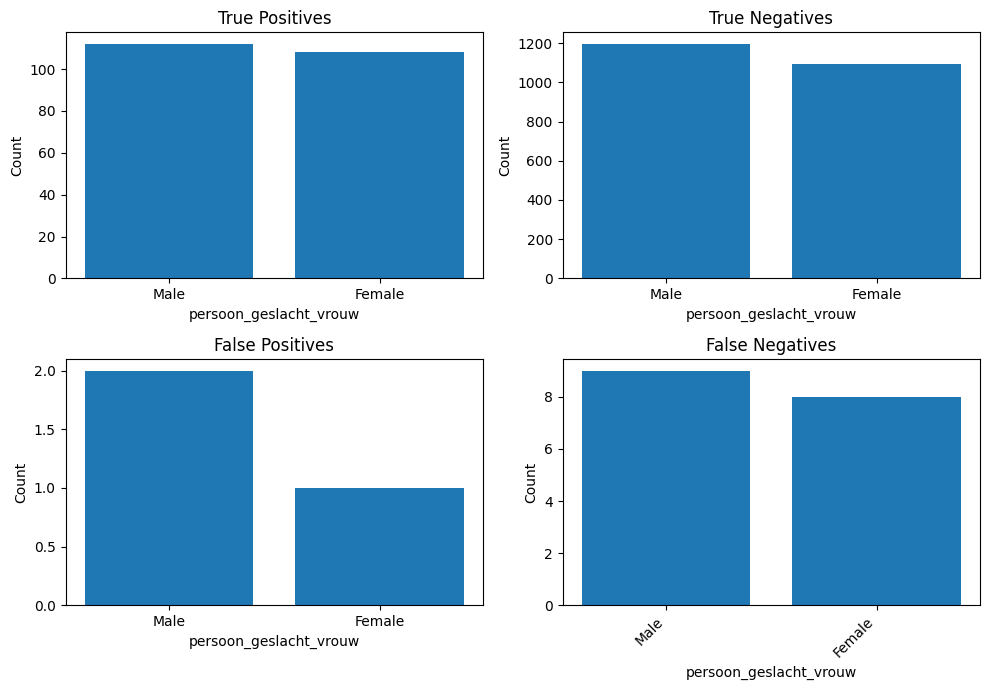

tn 2289 fp 3 fn 17 tp 220


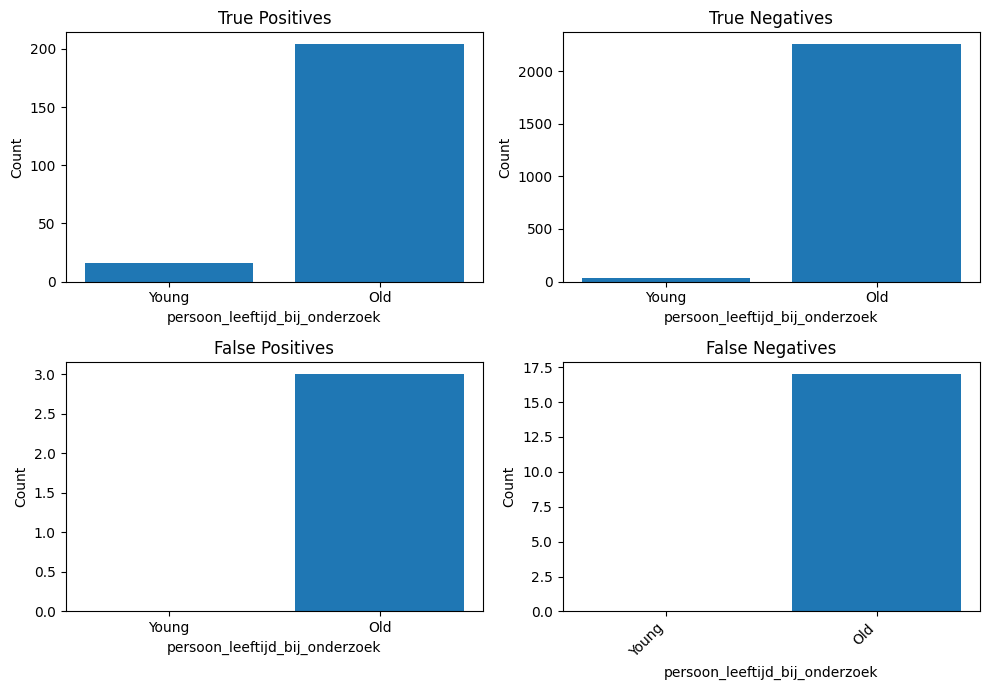

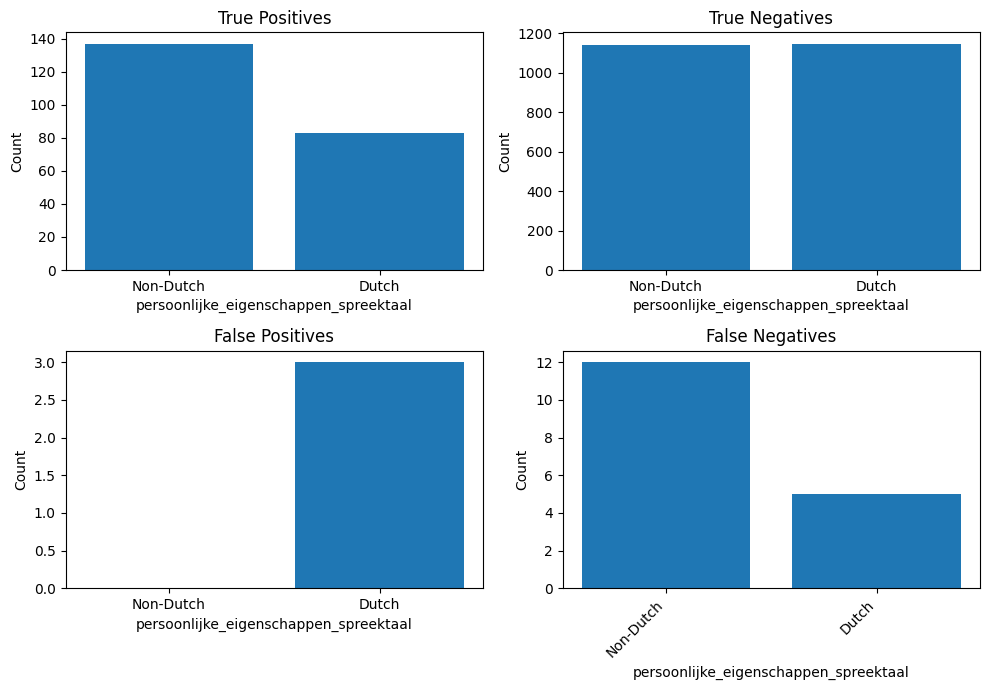

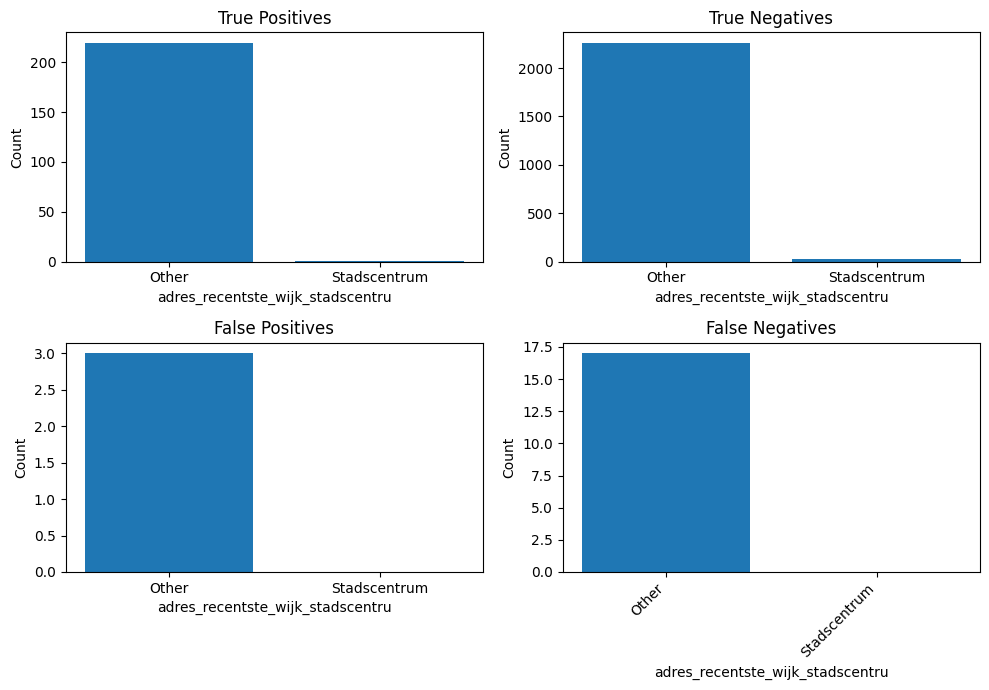

In [ ]:

# stats_evaluator = StatisticalEvaluation()
# stats_evaluator.plot_classification_by_feature(X_test, y_test, y_pred, feature_name1, feature_map={0: 'Male', 1: 'Female'})
# (tn, fp, fn, tp) = confusion_matrix(y_test, y_pred).ravel()
# print('tn', tn,  'fp', fp, 'fn', fn, 'tp', tp)
# stats_evaluator.plot_classification_by_feature(X_test_age, y_test, y_pred, feature_name2, feature_map={0: 'Young', 1: 'Old'})

# stats_evaluator.plot_classification_by_feature(X_test_lang, y_test, y_pred, feature_name3, feature_map={0: 'Non-Dutch', 1: 'Dutch'})

# stats_evaluator.plot_classification_by_feature(X_test, y_test, y_pred, feature_name4, feature_map={0: 'Other', 1: 'Stadscentrum'})
